# Здесь мы используем модель сегментации UNet для выполнения сегментации дорог в Massachusetts Roads Dataset.

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import pandas as pd
from tqdm import tqdm
import sys
import glob
import cv2

import pydicom
from sklearn.utils import shuffle

#import albumentations as A

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import  ReduceLROnPlateau

## Train и Test

In [3]:
import os
import pandas as pd

# Указываем путь к директории с данными
DATA_DIR = './data/tiff/'

# Создаем пути к директориям для обучающего, валидационного и тестового наборов данных
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

# Загружаем словарь классов из файла
class_dict = pd.read_csv("./data/label_class_dict.csv")

# Получаем имена классов
class_names = class_dict['name'].tolist()

# Получаем RGB-значения
class_rgb_values = class_dict[['r','g','b']].values.tolist()


print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### список конкретных классов для сегментации (если было много классов)


In [4]:
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Вспомогательные функции

In [5]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()


# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map


# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis=-1)
    return x


# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


class RoadsDataset(torch.utils.data.Dataset):
    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # Если есть аугментации, то они применяются к изображению и маске.
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Если есть предобработка, то она также применяется к изображению и маске.
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask

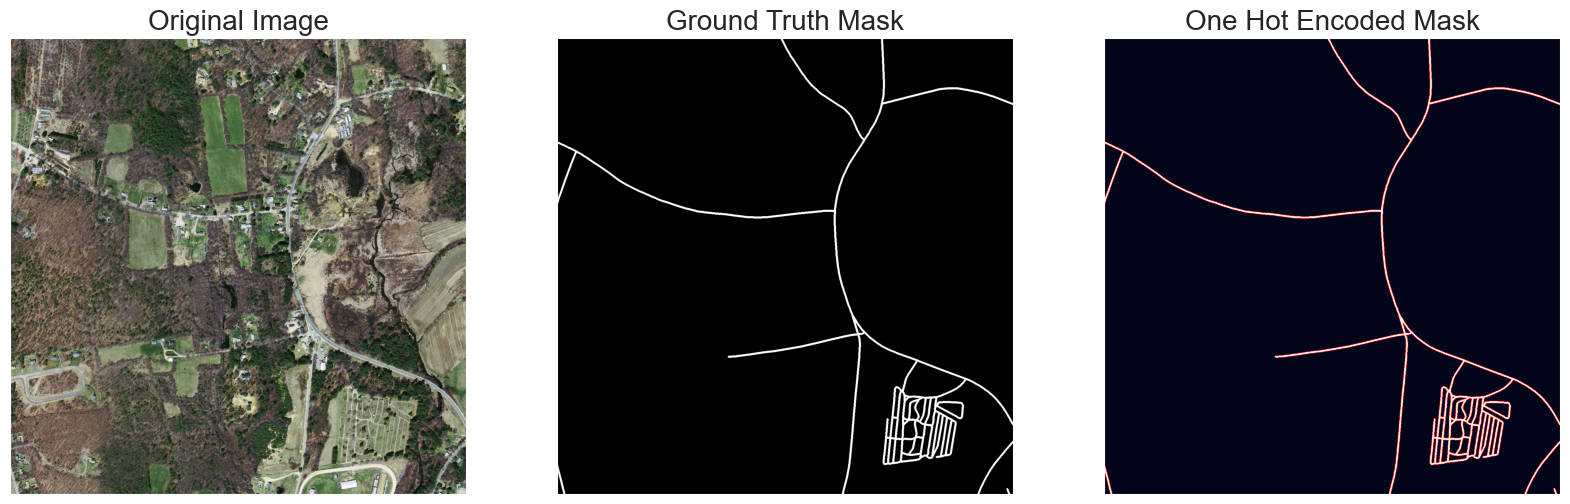

In [6]:

dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx ]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

In [7]:
len(dataset)

1108

### Defining Augmentations

In [8]:

def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

584


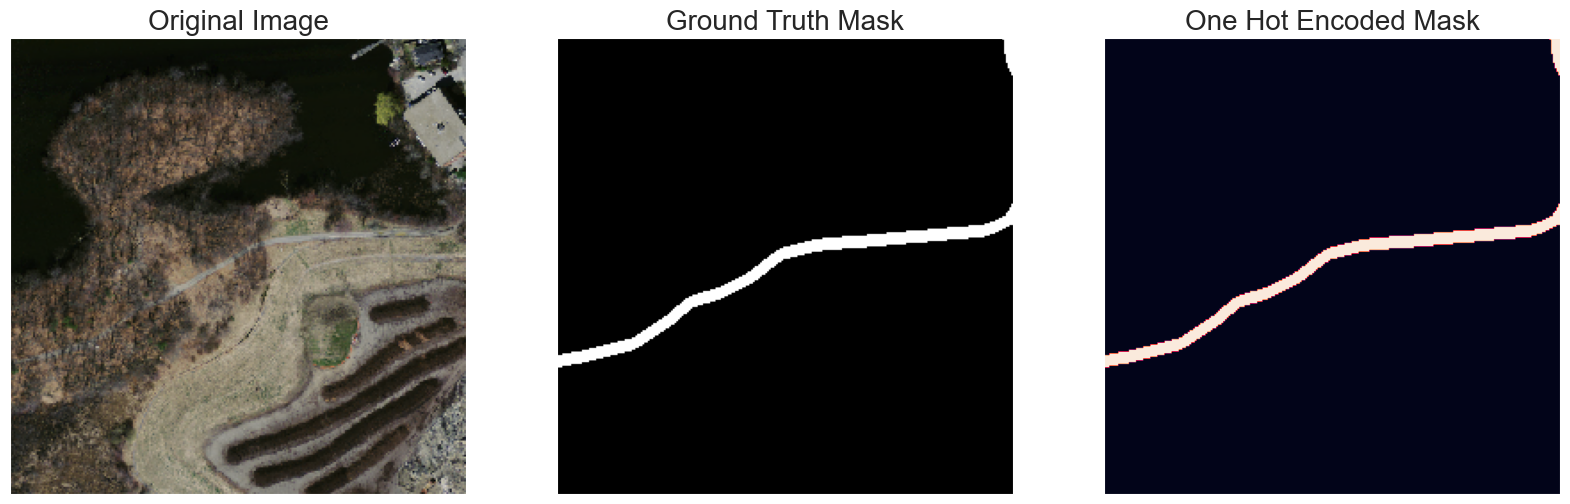

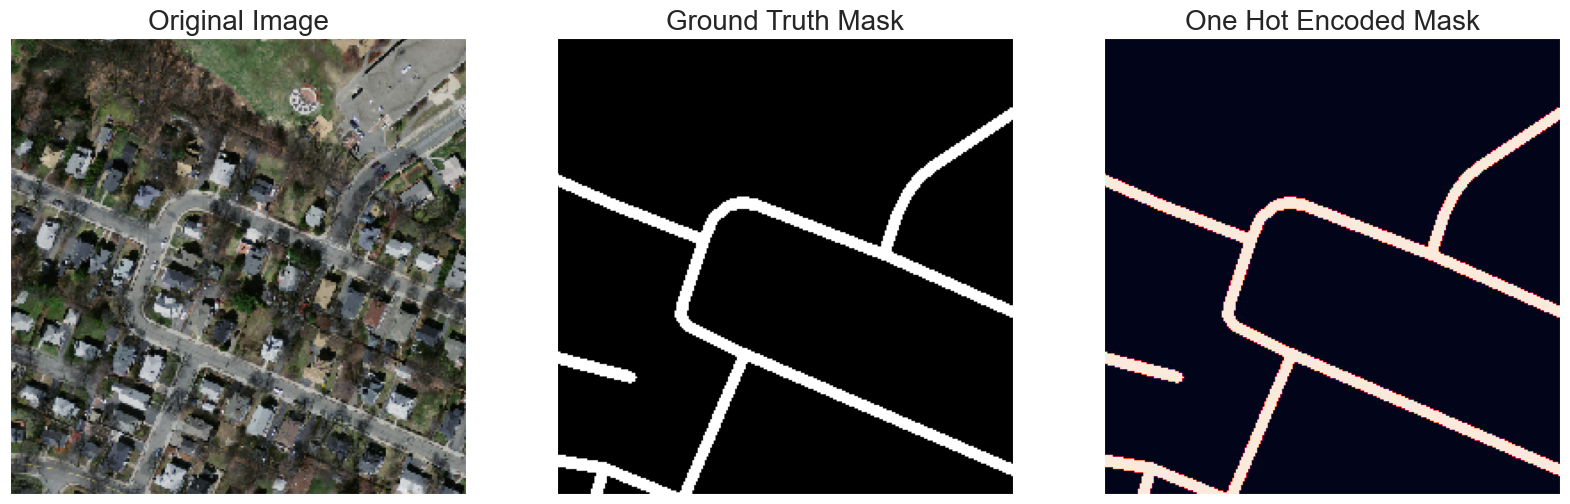

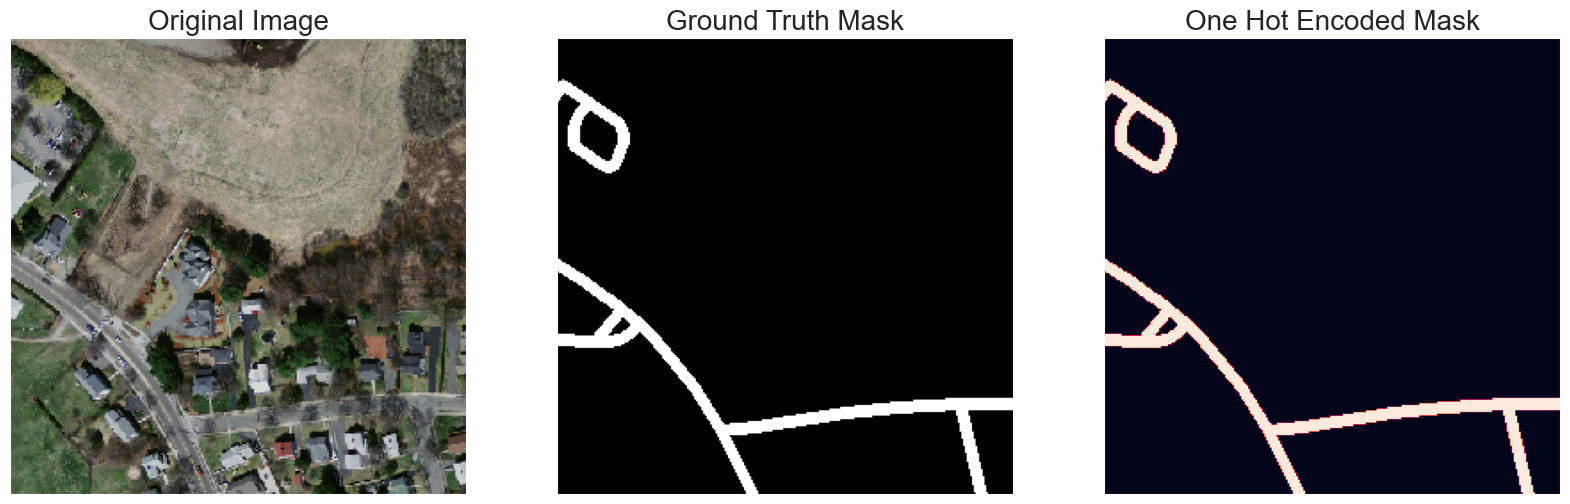

In [9]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)
print(random_idx)
# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image=image,
        ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask=reverse_one_hot(mask)
    )

## Training UNet (BASELINE)

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'  # поскольку это задача бинарной сегментации, используется функция активации сигмоиды

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#### Get Train / Val DataLoaders

In [11]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)



# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

### ПРИМЕР с уменьшеным датасетом

In [12]:
from torch.utils.data import Subset

# Функция для уменьшения датасета
def get_subset(dataset, num_samples):
    indices = list(range(len(dataset)))
    subset_indices = indices[:num_samples]
    subset = Subset(dataset, subset_indices)
    return subset

# Создание полного датасета
full_train_dataset = RoadsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

full_valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Уменьшение датасета до 60 изображений
N = 64
train_dataset = get_subset(full_train_dataset, N)
valid_dataset = get_subset(full_valid_dataset, N)

# Настройка загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [13]:
len(train_dataset)

64

### Гиперпараметры

In [14]:
import os
import torch
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import JaccardIndex
from torch.utils.data import DataLoader
import albumentations as album

In [15]:
#ВАРИАНТ 1
from segmentation_models_pytorch import utils as smp_utils
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 1 #5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [16]:
# import os
# import torch
# from segmentation_models_pytorch import Unet
# from segmentation_models_pytorch.encoders import get_preprocessing_fn
# from segmentation_models_pytorch.losses import DiceLoss
# from torchmetrics.classification import JaccardIndex
# from torch.utils.data import DataLoader
# import albumentations as album
#
# # Флаг для обучения модели
# TRAINING = True
#
# # Количество эпох
# EPOCHS = 3
#
# # Устройство для вычислений
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# # Определение функции потерь
# loss = DiceLoss(mode='binary')
#
# # Определение метрик
# metrics = [
#     JaccardIndex(task='binary'),
# ]
#
# # Оптимизатор
# optimizer = torch.optim.Adam([
#     dict(params=model.parameters(), lr=0.00008),
# ])
#
# # Планировщик скорости обучения
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# )
#
# # Загрузка сохраненной модели, если она существует
# if os.path.exists('best_model.pth'):
#     model = torch.load('best_model.pth', map_location=DEVICE)


# ТУТ!!

In [17]:
from segmentation_models_pytorch import utils as smp_utils

train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

# train_epoch = smp.utils.train.TrainEpoch(
#     model,
#     loss=loss,
#     metrics=metrics,
#     optimizer=optimizer,
#     device=DEVICE,
#     verbose=True,
# )

valid_epoch = smp_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/8 [00:00<?, ?it/s]

### Предсказываем

In [ ]:
#Загружаем модель
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Загрузка UNet с Resnet.')

In [ ]:
# с аугментацией
test_dataset = RoadsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# без аугменатции
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# Отображаем рандомно
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [18]:
 # т.к. изображения были дополнены до 1536x1536,приводим обратно
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [19]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
# Цикл по всем изображениям в тестовом наборе данных
for idx in range(len(test_dataset)):

    # Получаем изображение и маску из тестового набора данных
    image, gt_mask = test_dataset[idx]

    # Получаем визуализированное изображение и обрезаем его до оригинального размера
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))

    # Преобразуем изображение в тензор и перемещаем его на устройство
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Предсказываем маску сегментации дорог
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    pred_mask = np.transpose(pred_mask,(1,2,0))

    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]

    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

    # Сохраняем
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    # Визуализируем
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )


### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

#### IOU визуализируем

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('IoU Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('iou_score.png')
plt.show()

In [ ]:
model = smp.Unet(None